# Grid Intensity Forecasting

In [57]:
import gridemissions as ge
from power_dashboard.gridemissions_utils import load_bulk
import pandas as pd
from pathlib import Path
from typing import Union, List, Tuple
import matplotlib.pyplot as plt
from datetime import datetime
from functools import partial
import numpy as np
from time import time

##  Extract and transform gridemissions historical time series

In [2]:
co2i = load_bulk("../data/interim/gridemissions", "co2i")

Reshape into a long format with three columns.

In [3]:
all_ts = co2i.df.reset_index().melt(id_vars=['period'], var_name="region", value_name="CO2 Intensity").dropna()

In [6]:
# period represents "UTC Time at End of Hour" (see https://github.com/jdechalendar/gridemissions/blob/696838bc82c74aa40ab54206b36aec2026908a2d/src/gridemissions/eia_bulk_grid_monitor.py#L29)
# We need to localize the timestamp and subtract an hour to get to the beginning of the hour.
all_ts.period = all_ts.period.dt.tz_localize('UTC') - pd.Timedelta(hours=1)

In [108]:
all_ts.period.min(), all_ts.period.max()

(Timestamp('2018-07-01 04:00:00+0000', tz='UTC'),
 Timestamp('2024-06-15 06:00:00+0000', tz='UTC'))

In [109]:
recent_all_ts = pd.read_csv("../data/raw/recent_grid_emissions.csv", index_col=0, parse_dates=True)

In [111]:
recent_all_ts.index.min(), recent_all_ts.index.max()

(Timestamp('2024-07-07 21:00:00'), Timestamp('2024-07-21 20:00:00'))

Select the time-series for the ISNE region

In [7]:
df = all_ts.loc[all_ts['region'] == 'CO2i_ISNE_D'].dropna()
df.tail()

period       region  CO2 Intensity
1514578 2024-06-15 02:00:00+00:00  CO2i_ISNE_D     290.016321
1514579 2024-06-15 03:00:00+00:00  CO2i_ISNE_D     283.324206
1514580 2024-06-15 04:00:00+00:00  CO2i_ISNE_D     291.796152
1514581 2024-06-15 05:00:00+00:00  CO2i_ISNE_D     285.924739
1514582 2024-06-15 06:00:00+00:00  CO2i_ISNE_D     277.681349

In [8]:

df["local_time"] = df.period.dt.tz_convert('America/New_York')

### Evaluate the "best hours" of the day to charge.

Find the empirical 4-hour window of minimum grid intensity daily over the history, and evaluate how consistent the timing it is.  If it's almost always at the same time of day, a forecast is less important.

In [9]:
df["rolling_avg_intensity"] = df["CO2 Intensity"].rolling(window=4).mean()

In [21]:
def find_minimum_hour(
        df: pd.DataFrame,
        value_col: str,
        time_col: str,
        window: int=4
    ) -> Tuple[datetime, datetime]:
    """
    Find the minimum contiguous hours of a given length in a DataFrame
    """
    _df = df.reset_index()
    min_index = _df[value_col].idxmin()
    if not np.isnan(min_index):
        min_end = _df.loc[min_index, time_col]
        min_start = min_end - pd.Timedelta(hours=window)
        return (min_start, min_end)
    else:
        return (pd.NaT, pd.NaT)


In [22]:
_func = partial(find_minimum_hour, value_col="rolling_avg_intensity", time_col="local_time", window=4)

In [23]:
df.shape

(52227, 5)

In [24]:
assert not df.local_time.dt.date.isnull().any()

Text(0.5, 0, 'Hour of the Day')

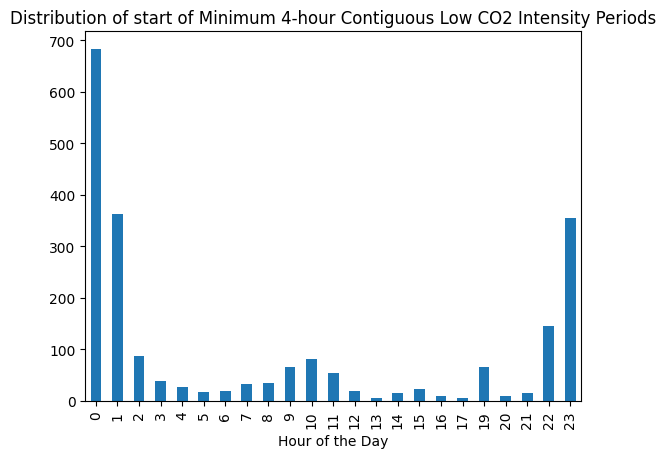

In [25]:
# df.groupby(df.period.dt.date).apply(lambda grp: _func(df=grp))
fig, ax = plt.subplots()

start_time_by_day = df.groupby(df.local_time.dt.date).apply(lambda grp: _func(df=grp)[0].hour)
start_time_by_day.value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title("Distribution of start of Minimum 4-hour Contiguous Low CO2 Intensity Periods")
ax.set_xlabel("Hour of the Day")


It looks like the minimum grid intensity happens by far the most frequently in the middle of the night, but sometimes it happens in the late morning. A forecast might be marginally helpful. 

#### Sanity check and visualization

In [26]:
sample_day = df.loc[df.local_time.dt.date.astype(str) == "2024-06-01"]

In [27]:
sample_day

period       region  CO2 Intensity  \
1514244 2024-06-01 04:00:00+00:00  CO2i_ISNE_D     265.097768   
1514245 2024-06-01 05:00:00+00:00  CO2i_ISNE_D     251.266000   
1514246 2024-06-01 06:00:00+00:00  CO2i_ISNE_D     238.440043   
1514247 2024-06-01 07:00:00+00:00  CO2i_ISNE_D     232.183765   
1514248 2024-06-01 08:00:00+00:00  CO2i_ISNE_D     229.336986   
1514249 2024-06-01 09:00:00+00:00  CO2i_ISNE_D     224.062074   
1514250 2024-06-01 10:00:00+00:00  CO2i_ISNE_D     219.388726   
1514251 2024-06-01 11:00:00+00:00  CO2i_ISNE_D     216.242176   
1514252 2024-06-01 12:00:00+00:00  CO2i_ISNE_D     210.125481   
1514253 2024-06-01 13:00:00+00:00  CO2i_ISNE_D     203.572875   
1514254 2024-06-01 14:00:00+00:00  CO2i_ISNE_D     208.798715   
1514255 2024-06-01 15:00:00+00:00  CO2i_ISNE_D     219.095621   
1514256 2024-06-01 16:00:00+00:00  CO2i_ISNE_D     224.699286   
1514257 2024-06-01 17:00:00+00:00  CO2i_ISNE_D     227.588292   
1514258 2024-06-01 18:00:00+00:00  CO2i_ISNE_D     236.493810   
1514259 2024-06-01 19:00:00+00:00  CO2i_ISNE_D     264.415583   
1514260 2024-06-01 20:00:00+00:00  CO2i_ISNE_D     294.265463   
1514261 2024-06-01 21:00:00+00:00  CO2i_ISNE_D     303.615956   
1514262 2024-06-01 22:00:00+00:00  CO2i_ISNE_D     298.396598   
1514263 2024-06-01 23:00:00+00:00  CO2i_ISNE_D     301.370265   
1514264 2024-06-02 00:00:00+00:00  CO2i_ISNE_D     310.516384   
1514265 2024-06-02 01:00:00+00:00  CO2i_ISNE_D     315.657828   
1514266 2024-06-02 02:00:00+00:00  CO2i_ISNE_D     312.959880   
1514267 2024-06-02 03:00:00+00:00  CO2i_ISNE_D     292.997336   

                       local_time  rolling_avg_intensity  
1514244 2024-06-01 00:00:00-04:00             276.477971  
1514245 2024-06-01 01:00:00-04:00             267.258029  
1514246 2024-06-01 02:00:00-04:00             256.842711  
1514247 2024-06-01 03:00:00-04:00             246.746894  
1514248 2024-06-01 04:00:00-04:00             237.806698  
1514249 2024-06-01 05:00:00-04:00             231.005717  
1514250 2024-06-01 06:00:00-04:00             226.242888  
1514251 2024-06-01 07:00:00-04:00             222.257490  
1514252 2024-06-01 08:00:00-04:00             217.454614  
1514253 2024-06-01 09:00:00-04:00             212.332314  
1514254 2024-06-01 10:00:00-04:00             209.684812  
1514255 2024-06-01 11:00:00-04:00             210.398173  
1514256 2024-06-01 12:00:00-04:00             214.041624  
1514257 2024-06-01 13:00:00-04:00             220.045479  
1514258 2024-06-01 14:00:00-04:00             226.969252  
1514259 2024-06-01 15:00:00-04:00             238.299243  
1514260 2024-06-01 16:00:00-04:00             255.690787  
1514261 2024-06-01 17:00:00-04:00             274.697703  
1514262 2024-06-01 18:00:00-04:00             290.173400  
1514263 2024-06-01 19:00:00-04:00             299.412070  
1514264 2024-06-01 20:00:00-04:00             303.474801  
1514265 2024-06-01 21:00:00-04:00             306.485269  
1514266 2024-06-01 22:00:00-04:00             310.126089  
1514267 2024-06-01 23:00:00-04:00             308.032857

In [28]:
_func(df=sample_day)

(Timestamp('2024-06-01 06:00:00-0400', tz='America/New_York'),
 Timestamp('2024-06-01 10:00:00-0400', tz='America/New_York'))

In [29]:
(min_start, min_end) = find_minimum_hour(sample_day, 'rolling_avg_intensity', 'local_time', 4)

print(f"The minimum 4-hour CO2 intensity period started at {min_start.hour}:00 and ended at {min_end.hour}:00")

The minimum 4-hour CO2 intensity period started at 6:00 and ended at 10:00


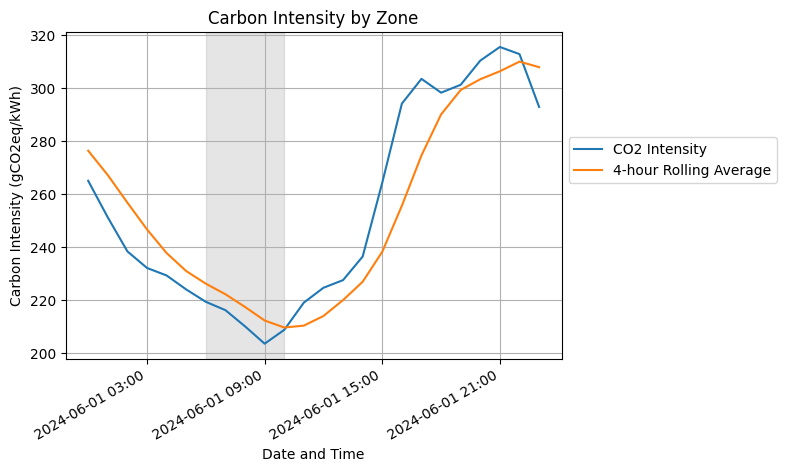

In [30]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()

ax.plot(sample_day['local_time'], sample_day['CO2 Intensity'], label="CO2 Intensity")

ax.plot(sample_day['local_time'], sample_day['rolling_avg_intensity'], label="4-hour Rolling Average")


# Add the shaded region directly using the localized timestamps
ax.axvspan(min_start, min_end, color='gray', alpha=0.2)
# ax.axvline(noon, color='red', linestyle='--')

# Set major locator to every hour
ax.xaxis.set_major_locator(mdates.HourLocator(interval=6, tz="America/New_York"))

# Set major formatter to show date and time
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M', tz="America/New_York"))

# Optional: rotate and align the tick labels so they look better
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
# Optional: add grid for better readability
ax.grid(True)
ax.legend(bbox_to_anchor=(1, 0.7))
ax.set_title("Carbon Intensity by Zone")
ax.set_ylabel("Carbon Intensity (gCO2eq/kWh)")
ax.set_xlabel("Date and Time")
fig.autofmt_xdate()
plt.show()

## Evaluate forecasting algorithms

Evaluate a minimum of two modeling algorithms using [time-series cross-validation](https://otexts.com/fpp3/tscv.html) and MAPE.

In [38]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA, SeasonalNaive

In [34]:
df.columns

Index(['period', 'region', 'CO2 Intensity', 'local_time',
       'rolling_avg_intensity'],
      dtype='object')

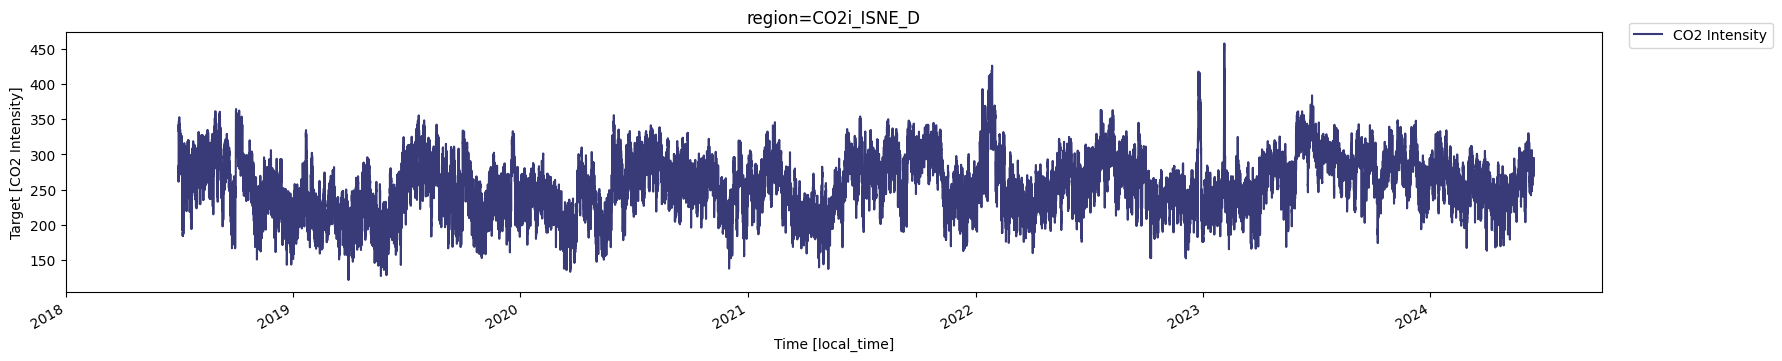

In [37]:
StatsForecast.plot(df, target_col='CO2 Intensity', time_col='local_time', id_col='region')


Define candidate model algorithms.

In [39]:
mstl = MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series
    trend_forecaster=AutoARIMA() # model used to forecast trend
)

seasonal_naive = SeasonalNaive(season_length=24)

In [42]:
sf = StatsForecast(
    models=[mstl, seasonal_naive],
    freq='H', # hourly frequency
)

In [46]:
df.loc[df.local_time.dt.year == 2023].shape

(8760, 5)

Fit 12 models and evaluate with a 24 hour forecast taken ~30 days apart.

In [49]:
df.tail()

period       region  CO2 Intensity  \
1514578 2024-06-15 02:00:00+00:00  CO2i_ISNE_D     290.016321   
1514579 2024-06-15 03:00:00+00:00  CO2i_ISNE_D     283.324206   
1514580 2024-06-15 04:00:00+00:00  CO2i_ISNE_D     291.796152   
1514581 2024-06-15 05:00:00+00:00  CO2i_ISNE_D     285.924739   
1514582 2024-06-15 06:00:00+00:00  CO2i_ISNE_D     277.681349   

                       local_time  rolling_avg_intensity  
1514578 2024-06-14 22:00:00-04:00             293.016744  
1514579 2024-06-14 23:00:00-04:00             290.710500  
1514580 2024-06-15 00:00:00-04:00             290.044026  
1514581 2024-06-15 01:00:00-04:00             287.765355  
1514582 2024-06-15 02:00:00-04:00             284.681612

In [52]:
_df = df[["region", "local_time", "CO2 Intensity"]].copy()
_df.columns = ["unique_id", "ds", "y"]

crossvalidation_df = sf.cross_validation(
    df = _df,
    h = 24,
    step_size = 24*30,
    n_windows = 12,
    # id_col='region',
    # target_col='CO2 Intensity',
    # time_col='local_time',
  )

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [54]:
from datasetsforecast.losses import rmse, mape

crossvalidation_df.head()

for model in ["MSTL", "SeasonalNaive"]:
    rmse_val = rmse(crossvalidation_df['y'], crossvalidation_df[model])
    mape_val = mape(crossvalidation_df['y'], crossvalidation_df[model])
    print(f"RMSE for {model}: {rmse_val}")
    print(f"MAPE for {model}: {mape_val}")





RMSE for MSTL: 16.749845504760742
MAPE for MSTL: 4.680657386779785
RMSE for SeasonalNaive: 27.554412841796875
MAPE for SeasonalNaive: 7.1020640432834625


In [ ]:
# Do we really need years of history?  I'm realizing we need recent history to use these forecasting methods
# for inference, and I only have 5 days of history at the moment.  Can we do well with five days of history?
# Let's try it out.


The MSTL model outperforms the SeasonalNaive model, so we'll use that.

## Fit the selected model class on all available history

In [66]:
#Keep one week of data for test and sanity check
df_test = _df.tail(24)
df_train = _df.drop(df_test.index)

In [67]:
sf_final =  StatsForecast(
    models=[mstl], # add SeasonalNaive model to the list
    freq='H'
)

In [68]:
df_train.head()

unique_id                        ds           y
1462356  CO2i_ISNE_D 2018-07-01 00:00:00-04:00  282.989417
1462357  CO2i_ISNE_D 2018-07-01 01:00:00-04:00  273.393594
1462358  CO2i_ISNE_D 2018-07-01 02:00:00-04:00  274.670704
1462359  CO2i_ISNE_D 2018-07-01 03:00:00-04:00  273.813093
1462360  CO2i_ISNE_D 2018-07-01 04:00:00-04:00  269.970188

In [69]:
init = time()
sf = sf_final.fit(df=df_train)
forecasts_test = sf.predict(h=len(df_test), level=[90])
end = time()
forecasts_test.head()

/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/processing.py:438: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


ds        MSTL  MSTL-lo-90  MSTL-hi-90
unique_id                                                                
CO2i_ISNE_D 2024-06-14 03:00:00-04:00  276.734436  269.058258  284.410583
CO2i_ISNE_D 2024-06-14 04:00:00-04:00  276.747040  265.194641  288.299469
CO2i_ISNE_D 2024-06-14 05:00:00-04:00  274.100677  259.805145  288.396210
CO2i_ISNE_D 2024-06-14 06:00:00-04:00  277.670898  261.216980  294.124786
CO2i_ISNE_D 2024-06-14 07:00:00-04:00  271.367004  253.113083  289.620972

In [70]:
def plot_forecasts(y_hist, y_true, y_pred, models):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(24 * 14)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2)
    colors = ['orange', 'green', 'red']
    for model, color in zip(models, colors):
        ax.fill_between(df_plot.index,
                        df_plot[f'{model}-lo-90'],
                        df_plot[f'{model}-hi-90'],
                        alpha=.35,
                        color=color,
                        label=f'{model}-level-90')
    ax.set_title('Grid Intensity Hourly', fontsize=22)
    ax.set_ylabel('Grid Intensity (gCO2e/kWh)', fontsize=20)
    ax.set_xlabel('Timestamp [t]', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()

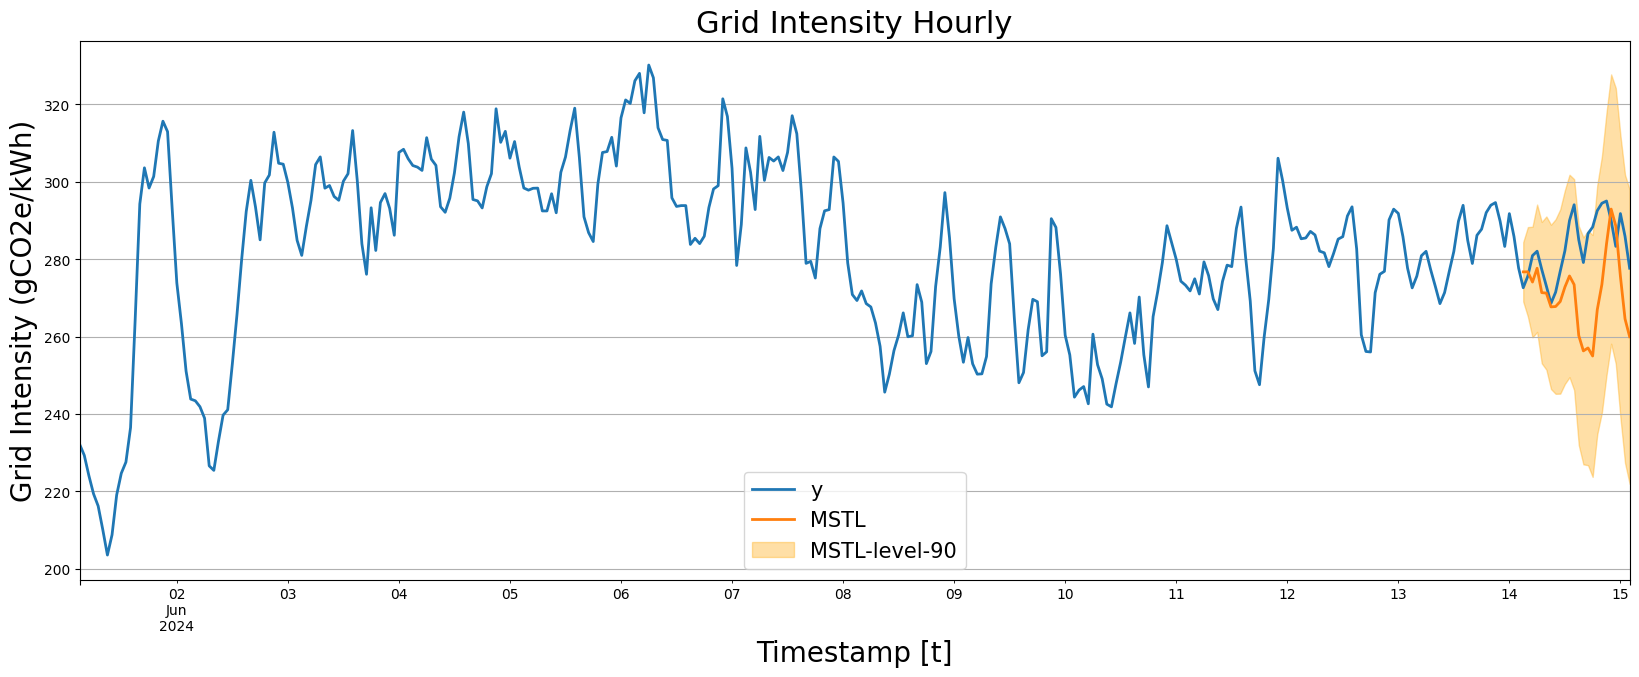

In [71]:
plot_forecasts(df_train, df_test, forecasts_test, models=['MSTL'])

## Fit an ML model capable of transfer forecasting

In [87]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
import lightgbm as lgb
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

In [158]:
def get_training_data(all_ts: pd.DataFrame, regions: List[str]):
    df = all_ts.loc[all_ts['region'].isin(regions)].dropna().copy()
    df["local_time"] = df.period.dt.tz_convert('America/New_York')
    return df

df = get_training_data(all_ts, ["CO2i_ISNE_D", "CO2i_WACM_D"])
_df = df[["region", "local_time", "CO2 Intensity"]].copy()
_df.columns = ["unique_id", "ds", "y"]

In [159]:
def plot_differences(df, differences):
    prep = [df]
    # Plot individual Differences
    for d in differences:
        fcst = MLForecast(
        models=[],  # we're not interested in modeling yet
        freq='H',  # our series have hourly frequency
        target_transforms=[Differences([d])],
        )
        df_ = fcst.preprocess(df)
        df_['unique_id'] = df_['unique_id'] + f'_{d}'
        prep.append(df_)

    # Plot combined Differences
    fcst = MLForecast(
        models=[],  # we're not interested in modeling yet
        freq='H',  # our series have hourly frequency
        target_transforms=[Differences([24, 24*7])],
    )
    df_ = fcst.preprocess(df)
    df_['unique_id'] = df_['unique_id'] + f'_all_diff'
    prep.append(df_)
    prep = pd.concat(prep, ignore_index=True)
    return prep

prep = plot_differences(_df, [24, 24*7])


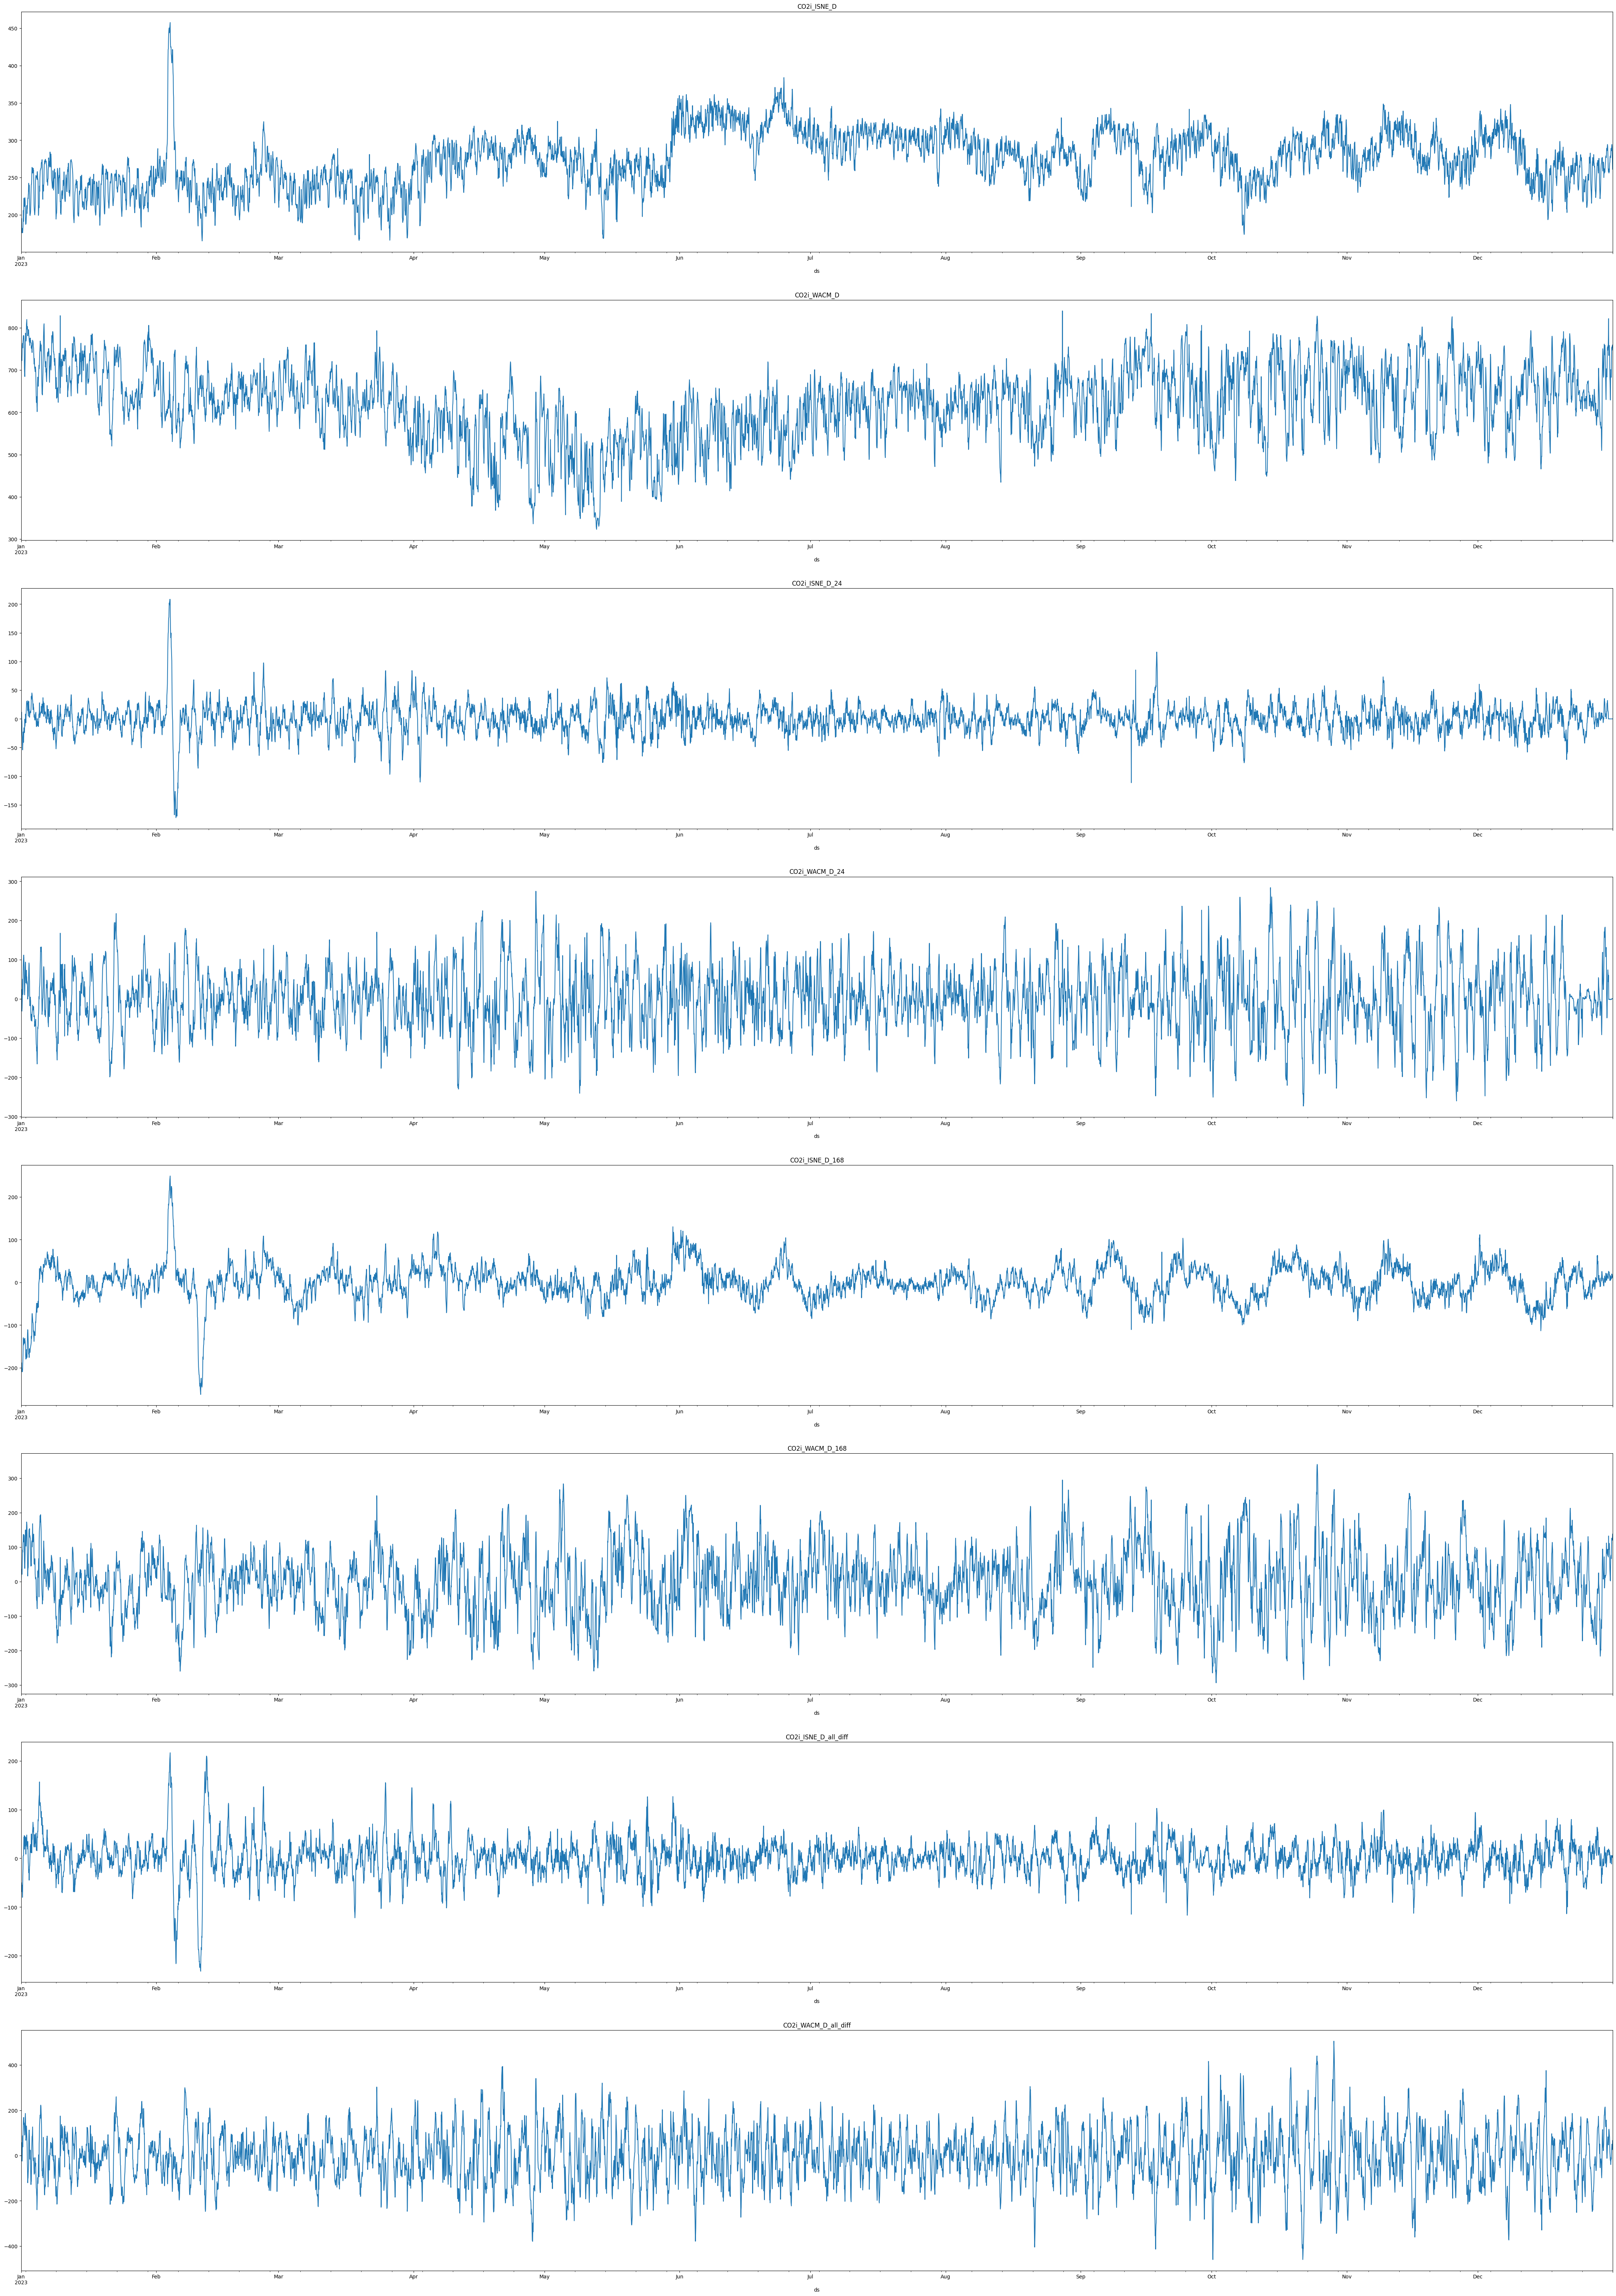

In [160]:
n_series = len(prep['unique_id'].unique())
fig, ax = plt.subplots(nrows=n_series, figsize=(7 * n_series, 10*n_series), squeeze=False)
for title, axi in zip(prep['unique_id'].unique(), ax.flat):
    df_ = prep[(prep['unique_id'] == title) & (prep['ds'].dt.year == 2023)]
    df_.set_index('ds')['y'].plot(title=title, ax=axi)

plt.show()


Create a benchmark Naive model that uses the level last hour as the prediction in the next timestep. This is not the same as predicting a constant, because we have transformed the target to differences.

In [162]:
#Keep one week of data for test and sanity check
df_test = _df.tail(24)
df_train = _df.drop(df_test.index)

In [163]:
df_train['unique_id'].unique()

array(['CO2i_ISNE_D', 'CO2i_WACM_D'], dtype=object)

In [164]:
from sklearn.base import BaseEstimator

class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']


In [165]:
models = {
    "naive": Naive(),
    "lgbm": lgb.LGBMRegressor(verbosity=-1)
}

In [166]:
mlf = MLForecast(
    models = models,
    freq='h',  # our series have hourly frequency
    target_transforms=[Differences([24])],
    lags=[1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,24], # Lags to be used as features
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=['month', 'hour', 'dayofweek']
)


In [167]:
features = mlf.preprocess(df_train)
features.head()

unique_id                        ds          y       lag1  \
1462451  CO2i_ISNE_D 2018-07-04 23:00:00-04:00 -17.540328  -8.994780   
1462452  CO2i_ISNE_D 2018-07-05 00:00:00-04:00  -9.439177 -17.540328   
1462453  CO2i_ISNE_D 2018-07-05 01:00:00-04:00   3.269848  -9.439177   
1462454  CO2i_ISNE_D 2018-07-05 02:00:00-04:00  -1.735247   3.269848   
1462455  CO2i_ISNE_D 2018-07-05 03:00:00-04:00  -6.751091  -1.735247   

              lag2       lag3       lag4       lag5       lag6       lag7  \
1462451 -11.731750 -11.588456  -5.856788  -2.116549 -10.336572 -10.494286   
1462452  -8.994780 -11.731750 -11.588456  -5.856788  -2.116549 -10.336572   
1462453 -17.540328  -8.994780 -11.731750 -11.588456  -5.856788  -2.116549   
1462454  -9.439177 -17.540328  -8.994780 -11.731750 -11.588456  -5.856788   
1462455   3.269848  -9.439177 -17.540328  -8.994780 -11.731750 -11.588456   

         ...       lag9      lag10      lag11      lag12      lag24  \
1462451  ...  -2.728631 -10.603085 -15.036857 -14.462325   8.232421   
1462452  ...  -3.663709  -2.728631 -10.603085 -15.036857  -6.166824   
1462453  ... -10.494286  -3.663709  -2.728631 -10.603085 -13.937093   
1462454  ... -10.336572 -10.494286  -3.663709  -2.728631 -14.334272   
1462455  ...  -2.116549 -10.336572 -10.494286  -3.663709  -9.605777   

         expanding_mean_lag1  rolling_mean_lag24_window_size48  month  hour  \
1462451            -1.261857                          4.360117      7    23   
1462452            -1.487946                          3.693617      7     0   
1462453            -1.596867                          2.705209      7     1   
1462454            -1.531101                          1.835699      7     2   
1462455            -1.533823                          1.124646      7     3   

         dayofweek  
1462451          2  
1462452          3  
1462453          3  
1462454          3  
1462455          3  

[5 rows x 21 columns]

In [168]:
cv_df = mlf.cross_validation(
    df=df_train,
    h=24,
    n_windows=40,
    refit=False,
)

In [169]:
cv_df.head()

unique_id                        ds                    cutoff  \
0  CO2i_ISNE_D 2024-05-06 03:00:00-04:00 2024-05-06 02:00:00-04:00   
1  CO2i_ISNE_D 2024-05-06 04:00:00-04:00 2024-05-06 02:00:00-04:00   
2  CO2i_ISNE_D 2024-05-06 05:00:00-04:00 2024-05-06 02:00:00-04:00   
3  CO2i_ISNE_D 2024-05-06 06:00:00-04:00 2024-05-06 02:00:00-04:00   
4  CO2i_ISNE_D 2024-05-06 07:00:00-04:00 2024-05-06 02:00:00-04:00   

            y       naive        lgbm  
0  237.310458  236.224872  236.032180  
1  238.993624  234.794363  233.824722  
2  243.244295  229.223298  228.283605  
3  254.416155  232.555376  231.586502  
4  256.019997  240.268194  237.427598

In [172]:
for region in cv_df['unique_id'].unique():
    for model in ["naive", "lgbm"]:
        _cv_df = cv_df.loc[cv_df['unique_id'] == region]
        rmse_val = rmse(_cv_df['y'], _cv_df[model])
        mape_val = mape(_cv_df['y'], _cv_df[model])
        print(f"RMSE for {model} in {region}: {rmse_val}")
        print(f"MAPE for {model} in {region}: {mape_val}")

RMSE for naive in CO2i_ISNE_D: 21.167963991734887
MAPE for naive in CO2i_ISNE_D: 6.121264787189373
RMSE for lgbm in CO2i_ISNE_D: 17.679457044499173
MAPE for lgbm in CO2i_ISNE_D: 5.047093313480551
RMSE for naive in CO2i_WACM_D: 94.29888074096675
MAPE for naive in CO2i_WACM_D: 15.144812640330851
RMSE for lgbm in CO2i_WACM_D: 66.61309446283843
MAPE for lgbm in CO2i_WACM_D: 11.139413510881841


In [117]:
def plot_cv(df, df_cv, uid, cutoffs=None, last_n=24 * 14, models={}, ax=None):
    if cutoffs is None:
        cutoffs = df_cv.query('unique_id == @uid')['cutoff'].unique()
    if ax is None:
        fig, ax = plt.subplots(nrows=len(cutoffs), ncols=1, figsize=(14, 14), gridspec_kw=dict(hspace=0.8))
    else:
        fig = ax[0].get_figure()
    for cutoff, axi in zip(cutoffs, ax.flat):
        print(f"Plotting {uid} for cutoff {cutoff}")
        max_date = df_cv.query('unique_id == @uid & cutoff == @cutoff')['ds'].max()
        df[df['ds'] < max_date].query('unique_id == @uid').tail(last_n).set_index('ds').plot(ax=axi, title=uid, y='y')
        for m in models.keys():
            df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax=axi, title=uid, y=m)

    return fig, ax



Plotting CO2i_ISNE_D for cutoff 2024-05-13 02:00:00-04:00
Plotting CO2i_ISNE_D for cutoff 2024-05-28 02:00:00-04:00
Plotting CO2i_ISNE_D for cutoff 2024-05-23 02:00:00-04:00
Plotting CO2i_ISNE_D for cutoff 2024-05-17 02:00:00-04:00
Plotting CO2i_ISNE_D for cutoff 2024-05-10 02:00:00-04:00


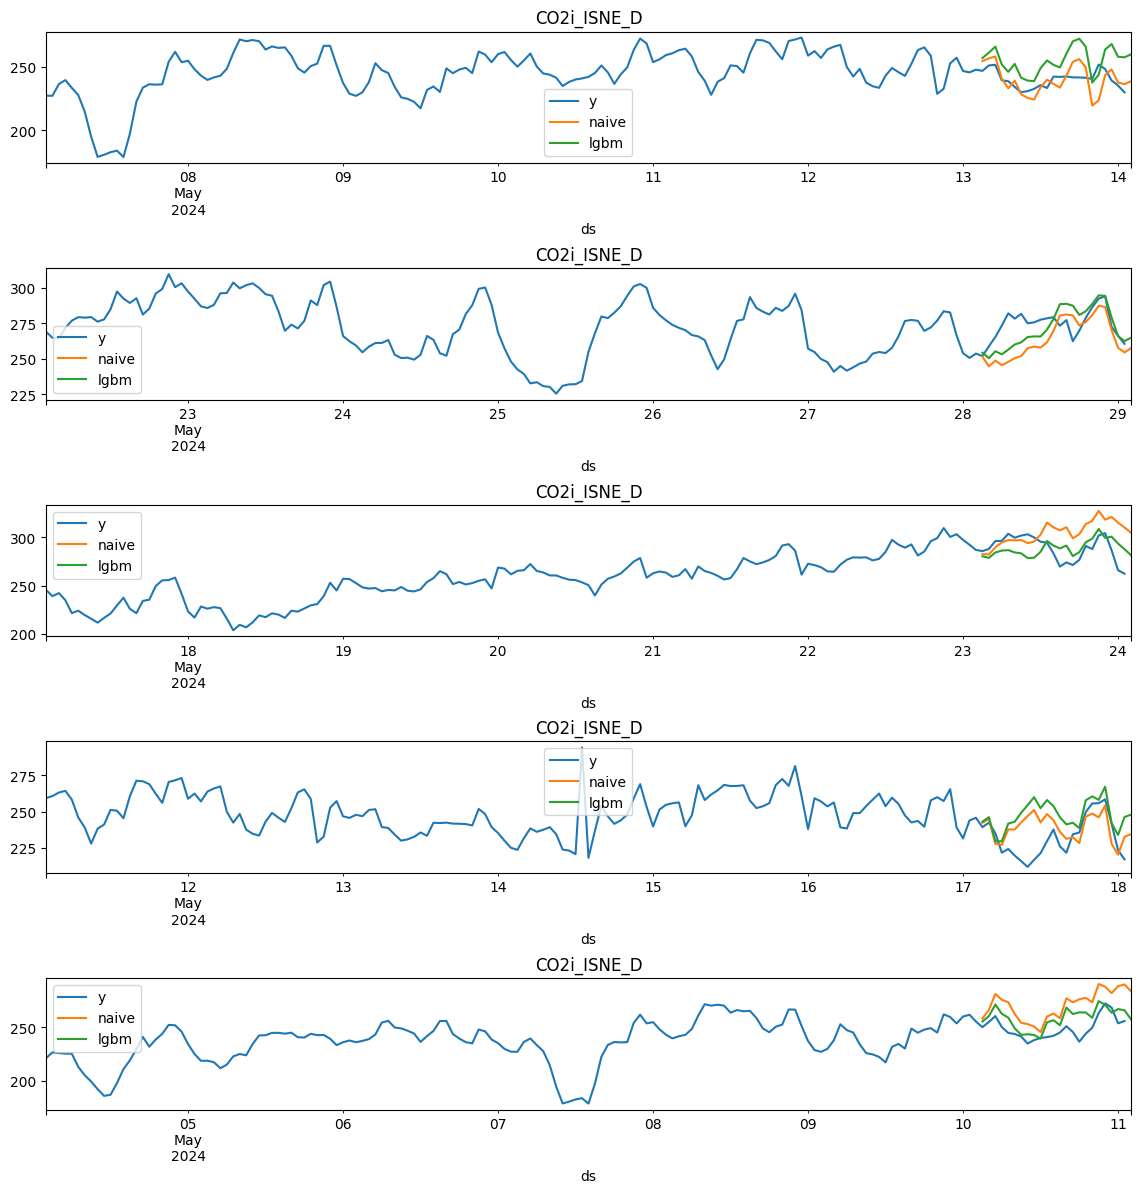

In [118]:

cutoffs = list(pd.Series(cv_df['cutoff'].unique()).sample(5))
fig, ax = plot_cv(df_train, cv_df, "CO2i_ISNE_D", cutoffs, last_n=24*7, models=models)
plt.show()

Plotting CO2i_WACM_D for cutoff 2024-05-13 02:00:00-04:00
Plotting CO2i_WACM_D for cutoff 2024-05-28 02:00:00-04:00
Plotting CO2i_WACM_D for cutoff 2024-05-23 02:00:00-04:00
Plotting CO2i_WACM_D for cutoff 2024-05-17 02:00:00-04:00
Plotting CO2i_WACM_D for cutoff 2024-05-10 02:00:00-04:00


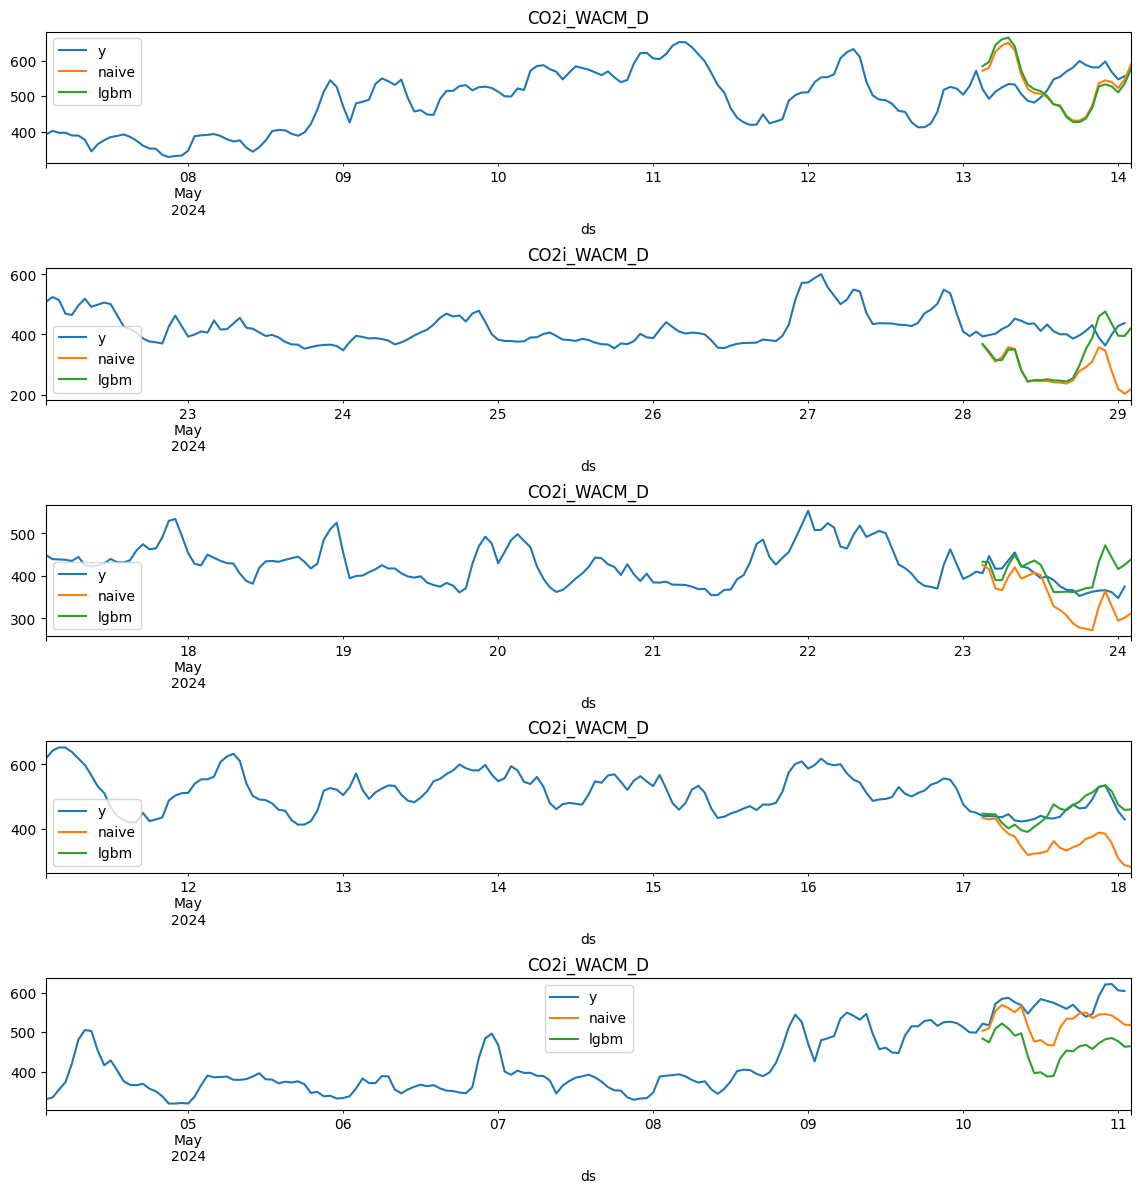

In [173]:
fig, ax = plot_cv(df_train, cv_df, "CO2i_WACM_D", cutoffs, last_n=24*7, models=models)
plt.show()

Performance isn't great, but let's move forward with this as a baseline option that can be used to forecast in the streamlit app.

In [174]:
mf_final =  mlf = MLForecast(
    models = [models["lgbm"]],
    freq='h',  # our series have hourly frequency
    target_transforms=[Differences([24])],
    lags=[1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,24], # Lags to be used as features
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=['month', 'hour', 'dayofweek']
)


In [175]:
init = time()
mf_final.fit(df=df_train)
forecasts_test = mf_final.predict(h=len(df_test))
end = time()
forecasts_test.head()

unique_id                        ds  LGBMRegressor
0  CO2i_ISNE_D 2024-06-15 03:00:00-04:00     271.059867
1  CO2i_ISNE_D 2024-06-15 04:00:00-04:00     273.001531
2  CO2i_ISNE_D 2024-06-15 05:00:00-04:00     278.408296
3  CO2i_ISNE_D 2024-06-15 06:00:00-04:00     279.547098
4  CO2i_ISNE_D 2024-06-15 07:00:00-04:00     274.841778

In [176]:
df_test.head()

unique_id                        ds           y
3081369  CO2i_WACM_D 2024-06-14 03:00:00-04:00  558.620583
3081370  CO2i_WACM_D 2024-06-14 04:00:00-04:00  532.368484
3081371  CO2i_WACM_D 2024-06-14 05:00:00-04:00  530.180600
3081372  CO2i_WACM_D 2024-06-14 06:00:00-04:00  559.282233
3081373  CO2i_WACM_D 2024-06-14 07:00:00-04:00  570.461820

KeyError: 'LGBMRegressor-lo-90'

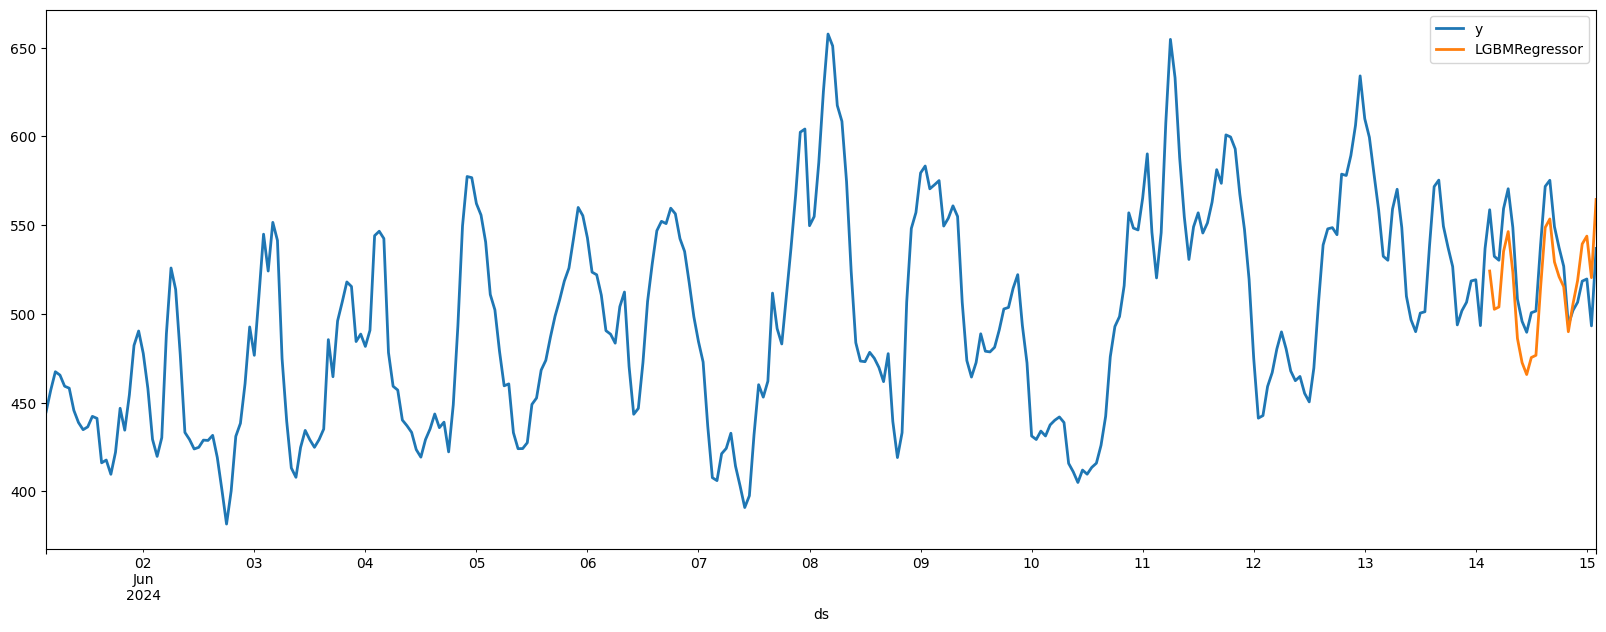

In [177]:
plot_forecasts(df_train, df_test, forecasts_test, models=['LGBMRegressor'])

## Save the final model and use for forecasting

In [179]:
!rm -rf ../models/final_model.pkl

86784.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [180]:
mf_final.save("../models/final_model/")

### Let's use the model to forecast based on the available history from ElectricityMaps

In [181]:
import os
from supabase import create_client, Client
import dotenv

dotenv.load_dotenv()

url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [182]:
response = supabase.table("electricitymaps-hourly").select("*").eq("testing", False).execute()

In [183]:
all_records = pd.DataFrame.from_records([
    record
    for resp in response.data
    for record in resp['carbon_intensity_raw']['history']
])
all_records.loc[~all_records.zone.str.startswith("CA")].sort_values(by='datetime', ascending=True)

zone                  datetime                 createdAt  \
24    US-NE-ISNE  2024-08-12T04:00:00.000Z  2024-08-09T04:54:56.972Z   
48    US-NW-WACM  2024-08-12T04:00:00.000Z  2024-08-09T04:54:32.766Z   
25    US-NE-ISNE  2024-08-12T05:00:00.000Z  2024-08-09T05:50:32.786Z   
120   US-NW-WACM  2024-08-12T05:00:00.000Z  2024-08-09T05:50:17.085Z   
96    US-NE-ISNE  2024-08-12T05:00:00.000Z  2024-08-09T05:50:32.786Z   
...          ...                       ...                       ...   
8135  US-NW-WACM  2024-08-17T19:00:00.000Z  2024-08-14T19:50:38.683Z   
8182  US-NE-ISNE  2024-08-17T19:00:00.000Z  2024-08-14T19:50:38.683Z   
8111  US-NE-ISNE  2024-08-17T19:00:00.000Z  2024-08-14T19:50:38.683Z   
8183  US-NE-ISNE  2024-08-17T20:00:00.000Z  2024-08-14T20:46:33.609Z   
8207  US-NW-WACM  2024-08-17T20:00:00.000Z  2024-08-14T20:47:23.880Z   

                     updatedAt  isEstimated  carbonIntensity  \
24    2024-08-12T12:47:22.783Z        False              306   
48    2024-08-12T11:49:04.509Z        False              708   
25    2024-08-12T12:47:32.789Z        False              301   
120   2024-08-12T11:49:04.509Z        False              789   
96    2024-08-12T12:47:32.789Z        False              301   
...                        ...          ...              ...   
8135  2024-08-17T18:49:51.312Z         True              663   
8182  2024-08-17T19:49:12.721Z        False              340   
8111  2024-08-17T18:50:38.548Z         True              324   
8183  2024-08-17T19:49:12.721Z         True              331   
8207  2024-08-17T19:49:12.721Z         True              683   

         estimationMethod emissionFactorType  
24                   None          lifecycle  
48                   None          lifecycle  
25                   None          lifecycle  
120                  None          lifecycle  
96                   None          lifecycle  
...                   ...                ...  
8135  TIME_SLICER_AVERAGE          lifecycle  
8182                 None          lifecycle  
8111  TIME_SLICER_AVERAGE          lifecycle  
8183  TIME_SLICER_AVERAGE          lifecycle  
8207  TIME_SLICER_AVERAGE          lifecycle  

[5472 rows x 8 columns]

In [184]:
# Within each zone,datetime group, select the record with maximum updatedAt value
idx = all_records.groupby(["zone", "datetime"])['updatedAt'].idxmax()
filtered_records = all_records.loc[idx].reset_index(drop=True)

datetime_cols = ["datetime", "createdAt", "updatedAt"]
filtered_records[datetime_cols] = filtered_records[datetime_cols].apply(pd.to_datetime).apply(lambda x: x.dt.tz_convert("America/New_York"))

In [189]:
emaps_us = filtered_records.loc[filtered_records.zone.str.startswith("US")].copy()

In [137]:
emaps_isne = filtered_records.query("zone == 'US-NE-ISNE'")
emaps_isne.shape

(137, 8)

In [186]:
emaps_wacm = filtered_records.query("zone == 'US-NW-WACM'")
emaps_wacm.shape

(137, 8)

In [200]:

final_times = emaps_us.datetime.sort_values().drop_duplicates().tail(24)
Y_test = emaps_us.loc[emaps_us.datetime.isin(final_times), ["datetime", "zone", "carbonIntensity"]].copy()
Y_train = emaps_us.drop(Y_test.index)[["datetime", "zone", "carbonIntensity"]].copy()
Y_test.columns = ["ds", "unique_id", "y"]
Y_train.columns = ["ds", "unique_id", "y"]
Y_train.shape[0], Y_test.shape[0]

(226, 48)

In [201]:
Y_test.unique_id.value_counts()

unique_id
US-NE-ISNE    24
US-NW-WACM    24
Name: count, dtype: int64

In [202]:
Y_hat_test = mf_final.predict(
    h=24,
    new_df=Y_train,
)
Y_hat_test


unique_id                        ds  LGBMRegressor
0   US-NE-ISNE 2024-08-16 17:00:00-04:00     301.633606
1   US-NE-ISNE 2024-08-16 18:00:00-04:00     304.462128
2   US-NE-ISNE 2024-08-16 19:00:00-04:00     316.529114
3   US-NE-ISNE 2024-08-16 20:00:00-04:00     324.410706
4   US-NE-ISNE 2024-08-16 21:00:00-04:00     346.610870
5   US-NE-ISNE 2024-08-16 22:00:00-04:00     349.977112
6   US-NE-ISNE 2024-08-16 23:00:00-04:00     336.891113
7   US-NE-ISNE 2024-08-17 00:00:00-04:00     323.832214
8   US-NE-ISNE 2024-08-17 01:00:00-04:00     322.104858
9   US-NE-ISNE 2024-08-17 02:00:00-04:00     320.084015
10  US-NE-ISNE 2024-08-17 03:00:00-04:00     314.806305
11  US-NE-ISNE 2024-08-17 04:00:00-04:00     316.806305
12  US-NE-ISNE 2024-08-17 05:00:00-04:00     318.088043
13  US-NE-ISNE 2024-08-17 06:00:00-04:00     321.088043
14  US-NE-ISNE 2024-08-17 07:00:00-04:00     324.806305
15  US-NE-ISNE 2024-08-17 08:00:00-04:00     322.778503
16  US-NE-ISNE 2024-08-17 09:00:00-04:00     319.942535
17  US-NE-ISNE 2024-08-17 10:00:00-04:00     325.942535
18  US-NE-ISNE 2024-08-17 11:00:00-04:00     324.942535
19  US-NE-ISNE 2024-08-17 12:00:00-04:00     326.942535
20  US-NE-ISNE 2024-08-17 13:00:00-04:00     334.970337
21  US-NE-ISNE 2024-08-17 14:00:00-04:00     337.365082
22  US-NE-ISNE 2024-08-17 15:00:00-04:00     325.365082
23  US-NE-ISNE 2024-08-17 16:00:00-04:00     295.778503
24  US-NW-WACM 2024-08-16 17:00:00-04:00     724.867615
25  US-NW-WACM 2024-08-16 18:00:00-04:00     738.011108
26  US-NW-WACM 2024-08-16 19:00:00-04:00     747.788391
27  US-NW-WACM 2024-08-16 20:00:00-04:00     752.100708
28  US-NW-WACM 2024-08-16 21:00:00-04:00     729.353210
29  US-NW-WACM 2024-08-16 22:00:00-04:00     661.169983
30  US-NW-WACM 2024-08-16 23:00:00-04:00     635.894958
31  US-NW-WACM 2024-08-17 00:00:00-04:00     644.878418
32  US-NW-WACM 2024-08-17 01:00:00-04:00     651.091797
33  US-NW-WACM 2024-08-17 02:00:00-04:00     649.725525
34  US-NW-WACM 2024-08-17 03:00:00-04:00     649.865112
35  US-NW-WACM 2024-08-17 04:00:00-04:00     598.806946
36  US-NW-WACM 2024-08-17 05:00:00-04:00     633.397888
37  US-NW-WACM 2024-08-17 06:00:00-04:00     650.556946
38  US-NW-WACM 2024-08-17 07:00:00-04:00     667.789978
39  US-NW-WACM 2024-08-17 08:00:00-04:00     670.860840
40  US-NW-WACM 2024-08-17 09:00:00-04:00     677.468994
41  US-NW-WACM 2024-08-17 10:00:00-04:00     682.540222
42  US-NW-WACM 2024-08-17 11:00:00-04:00     650.856873
43  US-NW-WACM 2024-08-17 12:00:00-04:00     662.593506
44  US-NW-WACM 2024-08-17 13:00:00-04:00     697.937866
45  US-NW-WACM 2024-08-17 14:00:00-04:00     721.036377
46  US-NW-WACM 2024-08-17 15:00:00-04:00     730.362305
47  US-NW-WACM 2024-08-17 16:00:00-04:00     702.538086

In [206]:
def plot_ml_forecasts(y_hist, y_true, y_pred, models):
    ts_ids = y_true['unique_id'].unique()
    _, axs = plt.subplots(len(ts_ids), 1, figsize = (20, 7))

    for i, unique_id in enumerate(ts_ids):
        _y_hist = y_hist.query('unique_id == @unique_id')
        _y_true = y_true.query('unique_id == @unique_id')
        _y_true = _y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
        df_plot = pd.concat([_y_hist, _y_true]).set_index('ds').tail(24 * 14)
        df_plot[['y'] + models].plot(ax=axs[i], linewidth=2)
        colors = ['orange', 'green', 'red']
        axs[i].set_title(f'Grid Intensity Hourly ({unique_id})', fontsize=22)
        axs[i].set_ylabel('Grid Intensity (gCO2e/kWh)', fontsize=20)
        axs[i].set_xlabel('Timestamp [t]', fontsize=20)
        axs[i].legend(prop={'size': 15})
        axs[i].grid()

In [207]:
len(Y_test['unique_id'].unique())

2

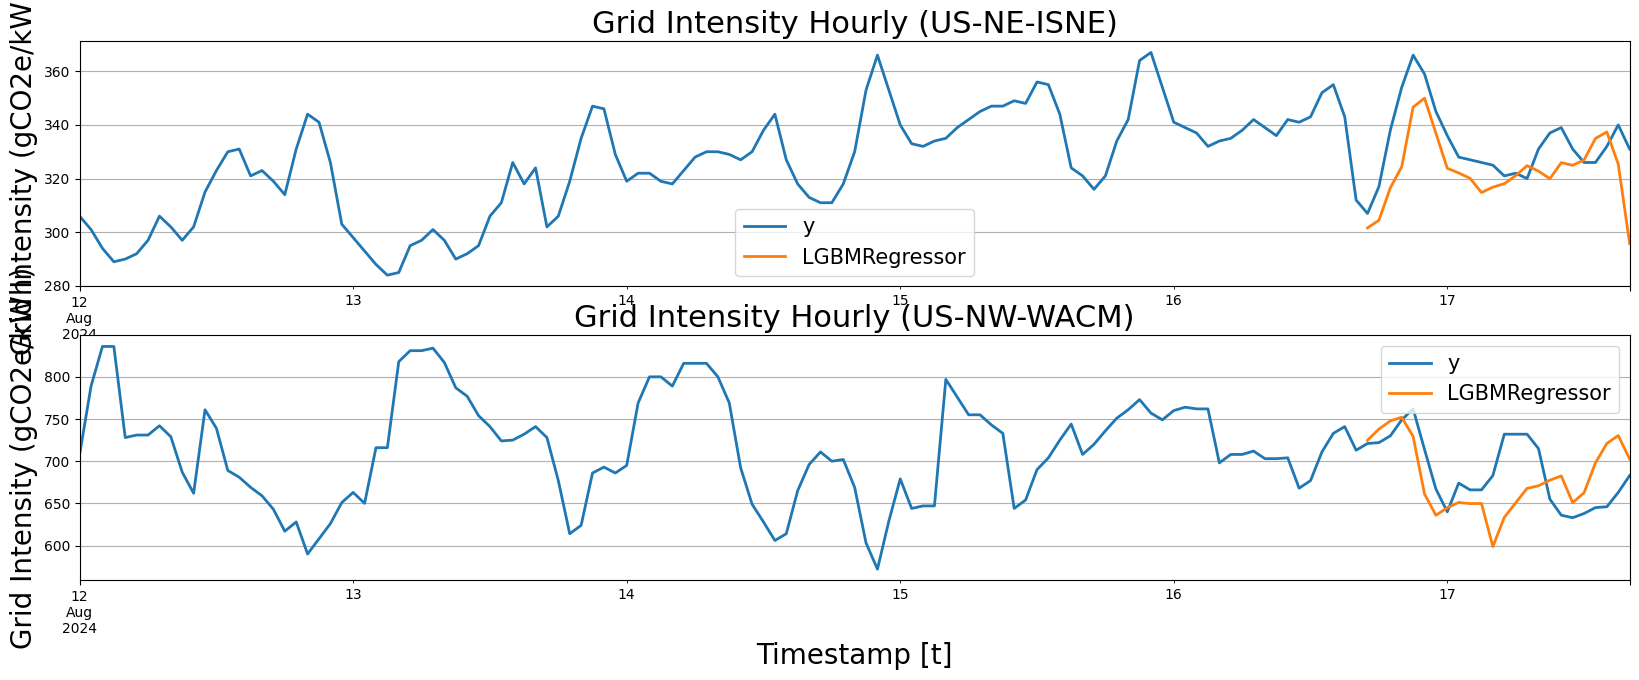

In [208]:
plot_ml_forecasts(Y_train, Y_test, Y_hat_test, models=['LGBMRegressor'])